In [27]:
# pip install scikit-learn matplotlib

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)


## 1. What is Clustering?

**Clustering** is an unsupervised learning task where we partition observations into groups (clusters) such that:
- Observations **within** a cluster are similar.
- Observations **across** clusters are dissimilar.

Unlike classification, we have **no labels** to guide us. The structure emerges purely from the data geometry.


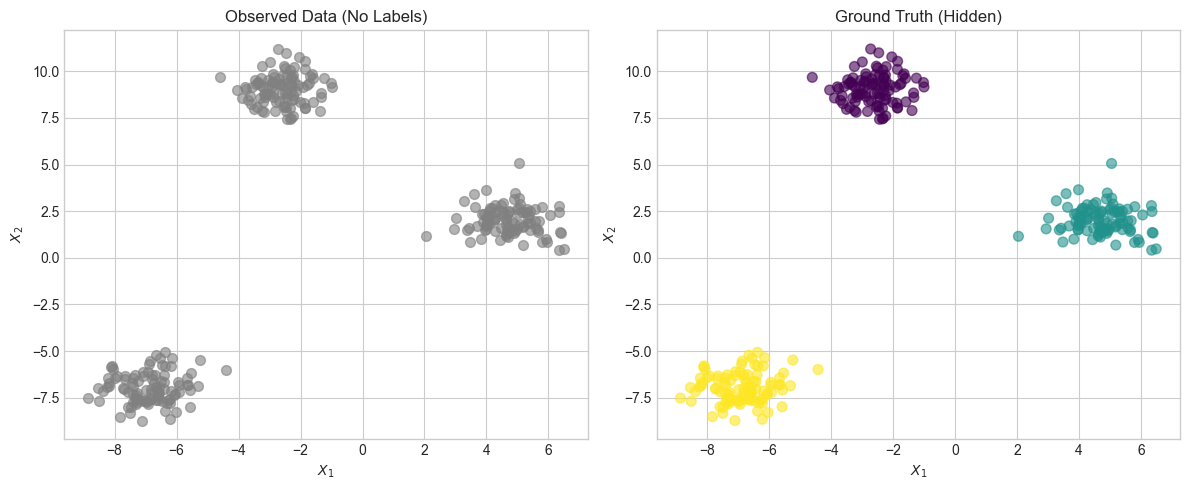

Dataset shape: (300, 2)


In [19]:
# Generate synthetic data with 3 clusters
X_synthetic, y_true = make_blobs(n_samples=300, centers=3, cluster_std=0.8, random_state=42)

# Visualize the data
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Data without labels (what we actually observe)
axes[0].scatter(X_synthetic[:, 0], X_synthetic[:, 1], c='gray', alpha=0.6, s=50)
axes[0].set_xlabel('$X_1$')
axes[0].set_ylabel('$X_2$')
axes[0].set_title('Observed Data (No Labels)')

# Right: Data with true labels (ground truth)
axes[1].scatter(X_synthetic[:, 0], X_synthetic[:, 1], c=y_true, cmap='viridis', alpha=0.6, s=50)
axes[1].set_xlabel('$X_1$')
axes[1].set_ylabel('$X_2$')
axes[1].set_title('Ground Truth (Hidden)')

plt.tight_layout()
plt.show()

print(f"Dataset shape: {X_synthetic.shape}")


## 2. K-Means Algorithm

**Objective**: Minimize the within-cluster sum of squares (WCSS):
$$J = \sum_{k=1}^{K} \sum_{i \in C_k} \|x_i - \mu_k\|^2$$

**Lloyd's Algorithm**:
1. **Initialize**: Randomly select $K$ points as initial centroids
2. **Assign**: Assign each point to the nearest centroid
3. **Update**: Recalculate centroids as the mean of assigned points
4. **Repeat** steps 2-3 until convergence (assignments don't change)

In [ ]:
def kmeans_scratch(X, K, max_iters=100, random_state=42):
    """
    K-Means clustering from scratch.
    
    Parameters:
        X: array of shape (n_samples, n_features)
        K: number of clusters
        max_iters: maximum iterations
    
    Returns:
        labels: cluster assignment for each point
        centroids: final centroid positions
        history: list of (centroids, labels) at each iteration
    """
    np.random.seed(random_state)
    n_samples, n_features = X.shape
    
    # Step 1: Initialize centroids randomly from data points
    idx = np.random.choice(n_samples, K, replace=False)
    centroids = X[idx].copy()
    
    history = []
    
    for iteration in range(max_iters):
        # Step 2: Assign each point to nearest centroid
        distances = np.zeros((n_samples, K))
        for k in range(K):
            distances[:, k] = np.linalg.norm(X - centroids[k], axis=1)
        labels = np.argmin(distances, axis=1)
        
        history.append((centroids.copy(), labels.copy()))
        
        # Step 3: Update centroids
        new_centroids = np.zeros((K, n_features))
        for k in range(K):
            if np.sum(labels == k) > 0:
                new_centroids[k] = X[labels == k].mean(axis=0)
            else:
                new_centroids[k] = centroids[k]  # Keep old if empty cluster
        
        # Check convergence
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    
    # Compute inertia (WCSS)
    inertia = sum(np.sum((X[labels == k] - centroids[k])**2) for k in range(K))
    
    return labels, centroids, history, inertia

# Apply our K-Means
labels_scratch, centers_scratch, history, inertia_scratch = kmeans_scratch(X_synthetic, K=3)

print(f"Converged in {len(history)} iterations")
print(f"Inertia (WCSS): {inertia_scratch:.2f}")

Converged in 3 iterations
Inertia (WCSS): 362.79


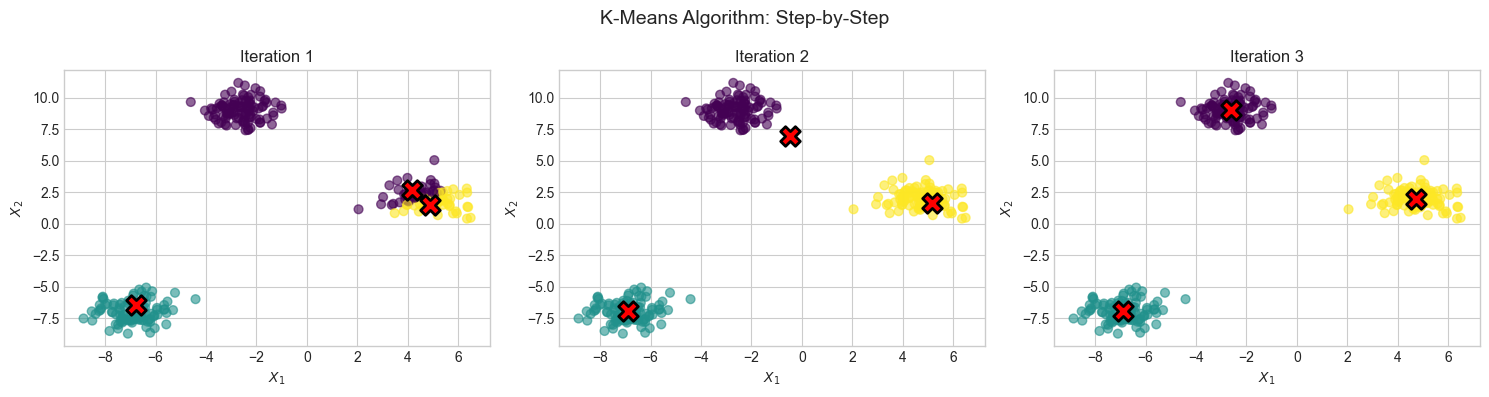

In [23]:
# Visualize the iteration process
n_iters = len(history)
n_plots = min(6, n_iters)
n_cols = min(3, n_plots)
n_rows = (n_plots + n_cols - 1) // n_cols

# Select iterations to show (evenly spaced + final)
if n_iters <= 6:
    iterations_to_show = list(range(n_iters))
else:
    iterations_to_show = [0, 1, 2, 3, 4, n_iters - 1]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = np.array(axes).flatten() if n_plots > 1 else [axes]

for idx, iter_num in enumerate(iterations_to_show):
    ax = axes[idx]
    centroids, labels = history[iter_num]
    ax.scatter(X_synthetic[:, 0], X_synthetic[:, 1], c=labels, cmap='viridis', alpha=0.6, s=40)
    ax.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, edgecolors='black', linewidths=2)
    ax.set_title(f'Iteration {iter_num + 1}')
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')

# Hide unused subplots
for idx in range(len(iterations_to_show), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('K-Means Algorithm: Step-by-Step', fontsize=14)
plt.tight_layout()
plt.show()


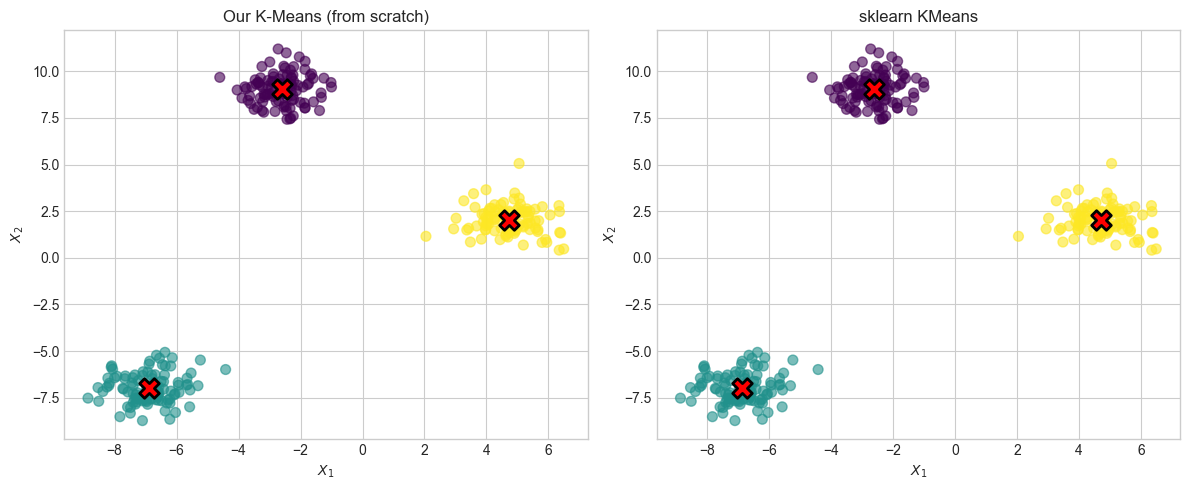

Our implementation - Inertia: 362.79
sklearn KMeans    - Inertia: 362.79


In [24]:
# Compare: sklearn KMeans vs our implementation
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_synthetic)
centers = kmeans.cluster_centers_

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(X_synthetic[:, 0], X_synthetic[:, 1], c=labels_scratch, cmap='viridis', alpha=0.6, s=50)
axes[0].scatter(centers_scratch[:, 0], centers_scratch[:, 1], c='red', marker='X', s=200, edgecolors='black', linewidths=2)
axes[0].set_xlabel('$X_1$')
axes[0].set_ylabel('$X_2$')
axes[0].set_title('Our K-Means (from scratch)')

axes[1].scatter(X_synthetic[:, 0], X_synthetic[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, s=50)
axes[1].scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, edgecolors='black', linewidths=2)
axes[1].set_xlabel('$X_1$')
axes[1].set_ylabel('$X_2$')
axes[1].set_title('sklearn KMeans')

plt.tight_layout()
plt.show()

print(f"Our implementation - Inertia: {inertia_scratch:.2f}")
print(f"sklearn KMeans    - Inertia: {kmeans.inertia_:.2f}")


## 3. Choosing K: Elbow Method and Silhouette Score

How do we choose the number of clusters $K$? 

**Elbow Method**: 
- **Inertia**: The within-cluster sum of squares $\sum_{k} \sum_{i \in C_k} \|x_i - \mu_k\|^2$. Lower = tighter clusters.
- Look for an "elbow" where adding more clusters yields diminishing returns.

**Silhouette Score**:
- **Score**: For each point, measures $(b - a) / \max(a, b)$ where:
  - $a$ = mean distance to points in the **same** cluster
  - $b$ = mean distance to points in the **nearest other** cluster
- Range: [-1, 1]. Higher = better separated clusters. Score near 0 means overlapping clusters.


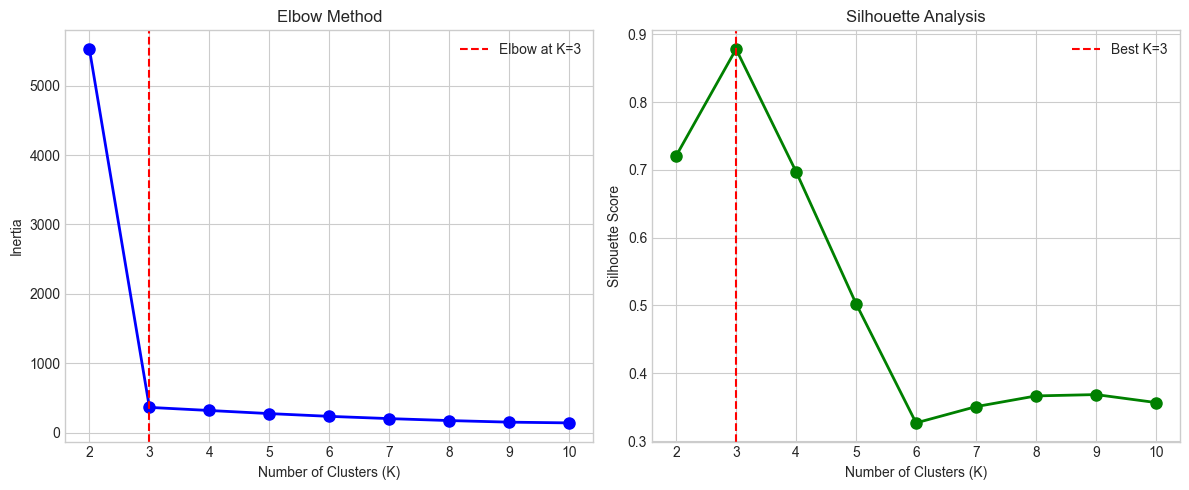

Best K based on Silhouette: 3


In [25]:
# Elbow Method and Silhouette Analysis (K=2 to 10)
# Note: K=1 causes numerical issues, so we start from K=2
K_range = range(2, 11)
inertias = []
silhouette_scores = []

# Compute inertias and silhouette scores for K=2 to 10
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_synthetic)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_synthetic, labels))

# Plot both metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(list(K_range), inertias, 'bo-', linewidth=2, markersize=8)
axes[0].axvline(x=3, color='red', linestyle='--', label='Elbow at K=3')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].legend()

axes[1].plot(list(K_range), silhouette_scores, 'go-', linewidth=2, markersize=8)
best_k = list(K_range)[np.argmax(silhouette_scores)]
axes[1].axvline(x=best_k, color='red', linestyle='--', label=f'Best K={best_k}')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Best K based on Silhouette: {best_k}")


## 4. Limitations of K-Means

K-Means has several limitations:
- **Must specify K in advance**
- **Assumes spherical clusters** (uses Euclidean distance)
- **Sensitive to initialization** (use `n_init` for multiple runs)
- **Fails on non-convex shapes**


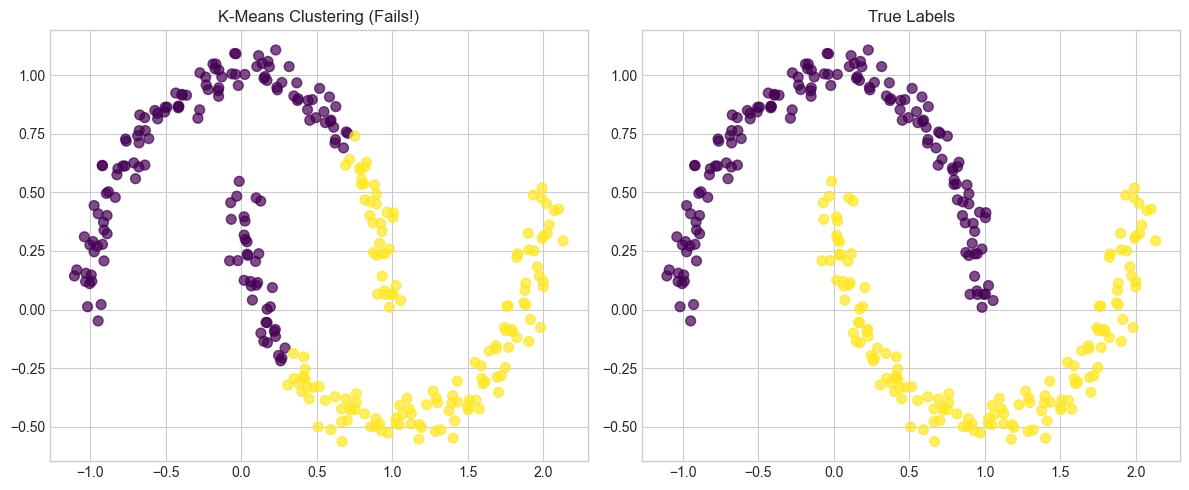

K-Means assumes spherical clusters and fails on crescent-shaped data.
Alternatives: DBSCAN, Spectral Clustering, Gaussian Mixture Models


In [26]:
# Example: K-Means fails on non-spherical data
X_moons, y_moons = make_moons(n_samples=300, noise=0.05, random_state=42)

kmeans_moons = KMeans(n_clusters=2, random_state=42, n_init=10)
moon_clusters = kmeans_moons.fit_predict(X_moons)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(X_moons[:, 0], X_moons[:, 1], c=moon_clusters, cmap='viridis', alpha=0.7, s=50)
axes[0].set_title('K-Means Clustering (Fails!)')

axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='viridis', alpha=0.7, s=50)
axes[1].set_title('True Labels')

plt.tight_layout()
plt.show()

print("K-Means assumes spherical clusters and fails on crescent-shaped data.")
print("Alternatives: DBSCAN, Spectral Clustering, Gaussian Mixture Models")
